In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt 
from dataloader import InsectDatamodule
import pickle
from sklearn.metrics import confusion_matrix
import numpy as np


In [2]:
class ResBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, n_max_pool: int, **kwargs):
        super().__init__()
        padding = kernel_size // 2

        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same', **kwargs)
        self.batchnorm1 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same', **kwargs)
        self.batchnorm2 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=n_max_pool, stride=n_max_pool)

    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out) + x
        return self.maxpool(out)


class ResNet(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, n_max_pool: int, n_res_blocks: int, num_classes: int, **kwargs):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same', **kwargs)
        self.batchnorm1 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        self.res_blocks = torch.nn.Sequential(
            *[ResBlock(
                in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, n_max_pool=n_max_pool, **kwargs) for _ in range(n_res_blocks)]
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.convout = torch.nn.Conv2d(in_channels=out_channels, out_channels=num_classes, kernel_size=1, **kwargs)

        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        # x: (N, C=1, H, W)
        x = x.unsqueeze(1)

        # Run input through a first convolutional layer.
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)

        # Run input through the residual blocks.
        out = self.res_blocks(out)

        # Run input through the average pooling layer. The output is a tensor of shape (N, C, 1, 1).
        out = self.avgpool(out)

        # Run input through the output convolutional layer. This is the same as a fully connected layer but it works with 4D tensors.
        out = self.convout(out)

        # Flatten the output tensor to have shape (N, C).
        out  = out.flatten(1)

        out = self.softmax(out)

        return out


In [3]:
csv_paths = ['../data/Cicadidae.csv', '../data/Orthoptera.csv']

batch_size = 10
num_workers = 0

n_fft = 1000
hop_length =  147
win_length = int(hop_length * 2)
n_mels = 64

datamodule = InsectDatamodule(csv_paths = csv_paths, batch_size = batch_size, num_workers = num_workers, hop_length = hop_length, n_fft = n_fft, win_length = win_length, n_mels = n_mels)

  0%|                                                                                             | 0/2 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 10.80s/it]


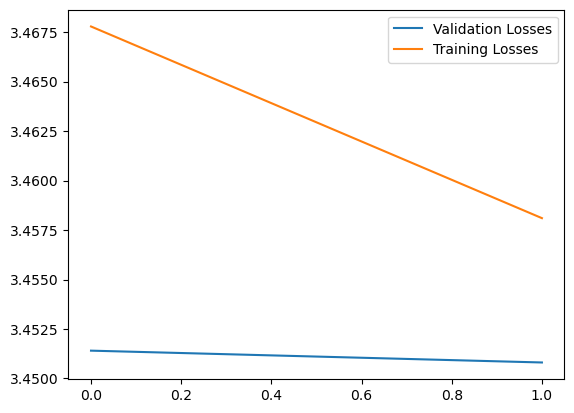

In [5]:
epochs = 1000

resnet = ResNet(in_channels=1, out_channels=32, kernel_size=3, n_max_pool=3, n_res_blocks=3, num_classes=datamodule.num_classes).cuda()
optimizer = torch.optim.AdamW(resnet.parameters(), lr=0.001, weight_decay=0.0)
cross_entropy = torch.nn.CrossEntropyLoss()

train_losses = []
train_losses_epoched = []

valid_losses = []
valid_losses_epoched = []


for epoch in tqdm(range(epochs), ncols=120):
    loss_sum = 0.
    num_losses = 0
    for x, y in datamodule.train_dataloader():
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        y_hat = resnet(x)
        loss = cross_entropy(y_hat, y.float())
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        num_losses += 1

        train_losses.append(loss.item())
    
    train_losses_epoched.append(loss_sum / num_losses)

    with torch.no_grad():
        loss_sum = 0.
        num_losses = 0
        for x, y in datamodule.val_dataloader():
            x = x.cuda()
            y = y.cuda()
            y_hat = resnet(x)
            loss = cross_entropy(y_hat, y.float())
            loss_sum += loss.item()
            num_losses += 1

            valid_losses.append(loss.item())

        valid_losses_epoched.append(loss_sum / num_losses)

# saving the Model
date = "2024-04-29"

torch.save(resnet.state_dict(), f'model_data/{date}model.pth')

with open(f'model_data/{date}train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses, f)

with open(f'model_data/{date}train_losses_epoched.pkl', 'wb') as f:
    pickle.dump(train_losses_epoched, f)

with open(f'model_data/{date}valid_losses.pkl', 'wb') as f:
    pickle.dump(valid_losses, f)

with open(f'model_data/{date}valid_losses_epoched.pkl', 'wb') as f:
    pickle.dump(valid_losses_epoched, f)

# Plotting the losses and saving the plot
plt.plot(valid_losses_epoched, label='Validation Losses')
plt.plot(train_losses_epoched, label='Training Losses')
plt.legend()

plt.savefig(f'model_data/{date}losses_plot.png')

In [4]:
torch.save(resnet.state_dict(), 'model_28.4.pth')

NameError: name 'resnet' is not defined

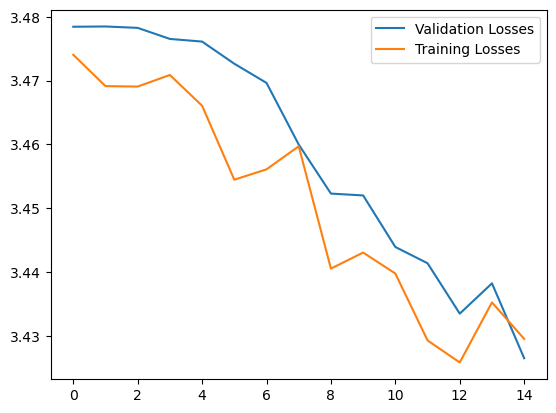

In [7]:
plt.plot(valid_losses_epoched, label='Validation Losses')
plt.plot(train_losses_epoched, label='Training Losses')
plt.legend()

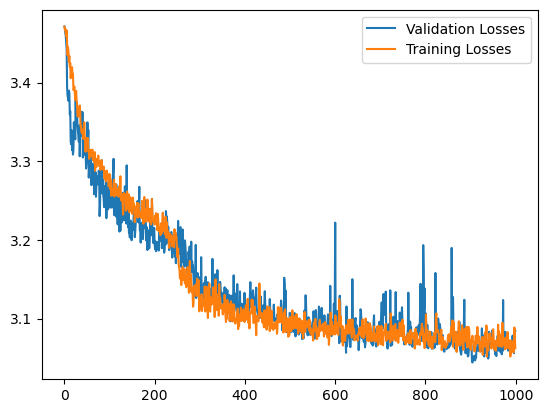

In [27]:
plt.plot(valid_losses_epoched, label='Validation Losses')
plt.plot(train_losses_epoched, label='Training Losses')
plt.legend()

In [5]:
# Initialize the model
resnet = ResNet(in_channels=1, out_channels=10, kernel_size=3, n_max_pool=3, n_res_blocks=3, num_classes=datamodule.num_classes).cuda()

# Load the state dict
state_dict = torch.load('model_28.4.pth')

# Update the model's parameters
resnet.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
resnet.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for x, y in datamodule.test_dataloader():
        x = x.cuda()
        y = y.cuda()
        y_hat = resnet(x)
        _, predicted = torch.max(y_hat, 1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(y_hat.cpu().numpy())
        

In [ ]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)
